# Importing packages for my tree models

In [3]:
# Importing the packages to prepare the mdoel and execute it...
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import shap

plt.rcParams["figure.figsize"] = (6, 4)

# Loading the case-only dataset
This cell reads the same cleaned dataset you used before.

In [15]:
# Loading all the dataset again and creatign datafile
baseTablePath = Path("C:/STS/My Project/StressMetastasis/Aim1/data/analysis_base_clean.csv")
df = pd.read_csv(baseTablePath)
print(df.columns.tolist())
print("Loaded shape:", df.shape)

['seqn', 'age_years', 'age_group', 'sex', 'race_eth', 'educ_level', 'pir', 'mcq220', 'ever_cancer', 'dpq_total', 'dpq_cat', 'smoke_status', 'hscrp_mg_l_raw', 'hscrp_cat', 'bmx_bmi', 'bmx_weight_kg', 'bmx_height_cm', 'bmx_waist_cm', 'bmx_hip_cm', 'dpq_severity', 'hscrp_flag_acute']
Loaded shape: (7800, 21)


# Selecting cancer cases only and creating the early vs late target

In [16]:
# I was getting an error in the model, so I changed the type to integer 
if "ever_cancer" in df.columns:
    outcome_col = "ever_cancer"
    df[outcome_col] = pd.to_numeric(df[outcome_col], errors="coerce").astype("Int64")
elif "mcq220" in df.columns:
    outcome_col = "mcq220"
    tmp = pd.to_numeric(df[outcome_col], errors="coerce").map({1: 1, 2: 0})
    df[outcome_col] = tmp.astype("Int64")
else:
    raise ValueError("Need a cancer indicator column.")

if "early_onset_proxy" not in df.columns:
    df["early_onset_proxy"] = (pd.to_numeric(df["age_years"], errors="coerce") < 50).astype(int)

cases = df[pd.to_numeric(df[outcome_col], errors="coerce") == 1].copy()
TARGET_COL = "early_onset_proxy"
print("Case-only shape:", cases.shape)

Case-only shape: (1169, 22)


# relevant variables

In [24]:
# make a copy of cases so we can add engineered columns
cases = cases.copy()

# create log CRP if raw CRP exists
if "hscrp_mg_l_raw" in cases.columns:
    cases["log_hscrp"] = np.log1p(cases["hscrp_mg_l_raw"])  # log(1+x) to avoid log(0)
else:
    cases["log_hscrp"] = np.nan

# numeric features that EXIST in your df
num_features = [c for c in [
    "dpq_total",      # depression score
    "log_hscrp",      # hscrp_mg_l_raw
    "pir",            # income ratio
    "age_years",
    "bmx_bmi"         # BMI column
] if c in cases.columns]

# categorical features that EXIST
cat_features = [c for c in [
    "smoke_status",
    "sex",
    "educ_level",
    "race_eth"
] if c in cases.columns]

# build encoded dataframe
cases_enc = pd.get_dummies(
    cases[num_features + cat_features + [TARGET_COL]],
    drop_first=True
)

X = cases_enc.drop(columns=[TARGET_COL])
y = cases_enc[TARGET_COL]

print("Numeric features:", num_features)
print("Categorical features:", cat_features)
print("Final X shape:", X.shape)
print("Final y shape:", y.shape)

Numeric features: ['dpq_total', 'log_hscrp', 'pir', 'age_years', 'bmx_bmi']
Categorical features: ['smoke_status', 'sex', 'educ_level', 'race_eth']
Final X shape: (1169, 10)
Final y shape: (1169,)


# Splits the dataset for training and evaluation.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (818, 10) Test: (351, 10)


# fiting the Random Forest model

In [19]:
# Random forest model :-)
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
print("Random Forest trained.")

Random Forest trained.


# fFts the XGBoost model with the parameters your professor suggested.

In [20]:
xgb_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=1.0,
    colsample_bytree=1.0,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
)
xgb_model.fit(X_train, y_train)
print("XGBoost trained.")

XGBoost trained.


# accuracy/AUC and saving ROC plots for both models

Random Forest Accuracy: 1.000
Random Forest AUC: 1.000


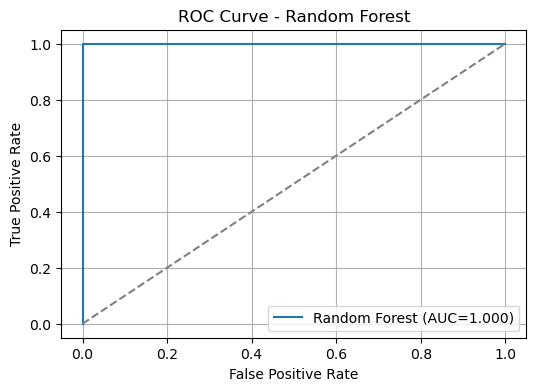

Saved ROC to roc_random_forest.png
XGBoost Accuracy: 1.000
XGBoost AUC: 1.000


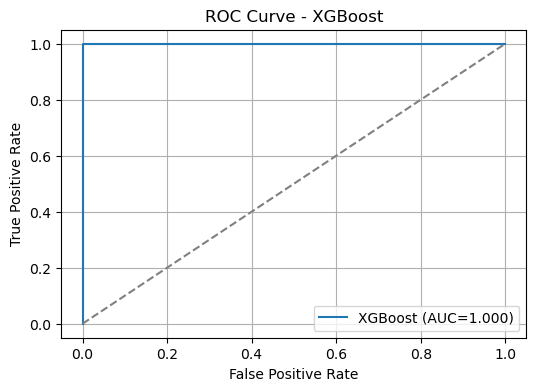

Saved ROC to roc_xgboost.png


In [21]:
def evaluate_model(model, X_test, y_test, model_name="model"):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    print(f"{model_name} Accuracy: {acc:.3f}")
    print(f"{model_name} AUC: {auc:.3f}")

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"{model_name} (AUC={auc:.3f})")
    plt.plot([0, 1], [0, 1], "--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()
    plt.grid(True)
    fname = f"roc_{model_name.lower().replace(' ', '_')}.png"
    plt.savefig(fname, dpi=150, bbox_inches="tight")
    plt.show()
    print("Saved ROC to", fname)

evaluate_model(rf, X_test, y_test, model_name="Random Forest")
evaluate_model(xgb_model, X_test, y_test, model_name="XGBoost")

#  variables which contributed the most.

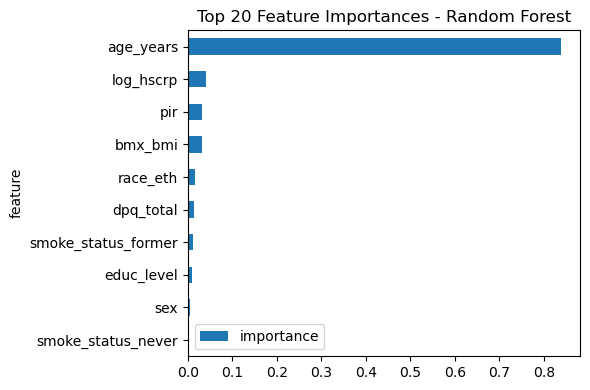

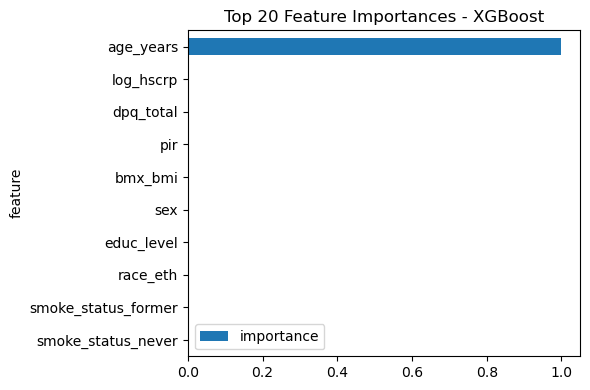

In [22]:
def plot_feature_importance(importances, feature_names, model_name="model", top_n=20):
    fi = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    }).sort_values("importance", ascending=False).head(top_n)

    fi.plot(kind="barh", x="feature", y="importance")
    plt.gca().invert_yaxis()
    plt.title(f"Top {top_n} Feature Importances - {model_name}")
    plt.tight_layout()
    plt.show()
    return fi

rf_fi = plot_feature_importance(rf.feature_importances_, X_train.columns, model_name="Random Forest")
xgb_fi = plot_feature_importance(xgb_model.feature_importances_, X_train.columns, model_name="XGBoost")

# SHAP for XGBoost

ExactExplainer explainer: 819it [00:36, 16.10it/s]                         


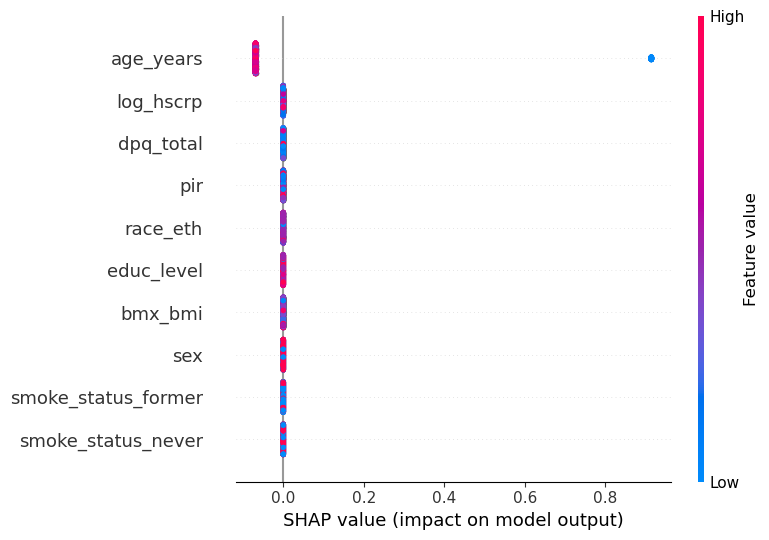

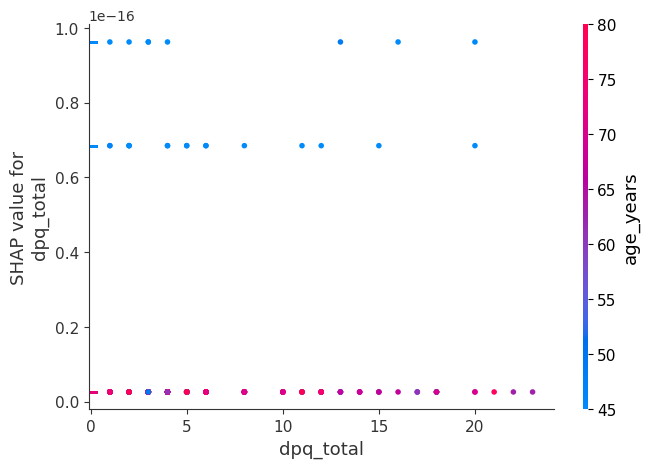

In [23]:
X_train_num = X_train.astype(float)
X_test_num = X_test.astype(float)

background = X_train_num.sample(200, random_state=42)

predict_fn = lambda X: xgb_model.predict_proba(X)[:, 1]

explainer = shap.Explainer(predict_fn, background)
shap_values = explainer(X_train_num)

shap.summary_plot(shap_values.values, X_train_num, show=False)
plt.savefig("shap_summary_xgboost.png", dpi=150, bbox_inches="tight")
plt.show()

PHQ_COL = "dpq_total"
if PHQ_COL in X_train_num.columns:
    shap.dependence_plot(PHQ_COL, shap_values.values, X_train_num, show=False)
    plt.savefig("shap_dependence_dpq_total_std.png", dpi=150, bbox_inches="tight")
    plt.show()
else:
    print(f"{PHQ_COL} not found in columns.")